In [1]:
import os
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import calplot

from obspy import read, read_inventory, UTCDateTime

In [2]:
path = 'data/'

In [3]:
files = os.listdir(path)
files.sort()

In [4]:
files[:10]

['2000_01_01_00_00_00.mseed',
 '2000_01_01_01_00_00.mseed',
 '2000_01_01_02_00_00.mseed',
 '2000_01_01_03_00_00.mseed',
 '2000_01_01_04_00_00.mseed',
 '2000_01_02_00_00_00.mseed',
 '2000_01_02_01_00_00.mseed',
 '2000_01_02_02_00_00.mseed',
 '2000_01_02_03_00_00.mseed',
 '2000_01_02_04_00_00.mseed']

In [61]:
files = [file for file in files if file not in bad_files]

In [5]:
datetimes = [datetime.strptime(date_str, "%Y_%m_%d_%H_%M_%S.mseed") for date_str in files]

In [6]:
sizes = [os.path.getsize(os.path.join(path, file))/1000 for file in files]

In [7]:
print(f'Number of files : {len(files)}\nTotal size : {np.sum(sizes)/1000/1000:.2f} Go')

Number of files : 185090
Total size : 13.11 Go


In [8]:
starttime = UTCDateTime(2000, 1, 1, 0, 0, 0)
endtime = UTCDateTime(2024, 1, 1, 0, 0, 0)
duration = 60*60
windows = np.arange(starttime, endtime, duration)
print(f'Estimated : {len(windows)}\nRatio : {len(files)/len(windows)*100:.2f} %')

Estimated : 210384
Ratio : 87.98 %


In [10]:
inventory = read_inventory('metadata/inventory.xml', format='STATIONXML')
inv_sta = inventory.select(network='G', station='DRV', channel='BHZ')[0][0]

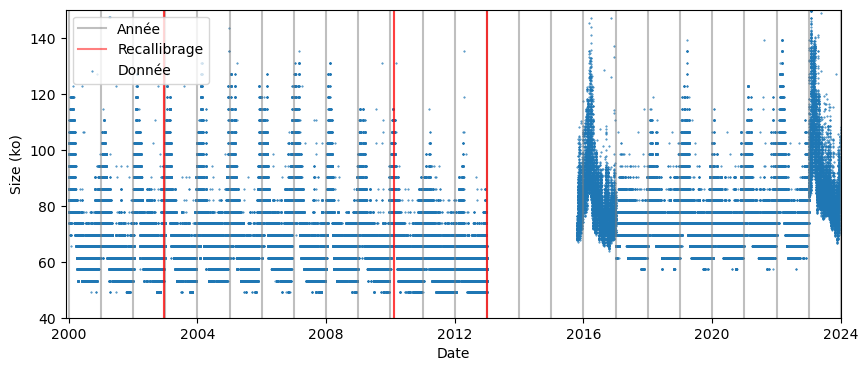

In [110]:
plt.figure(figsize=(10, 4))

label = 'Année'
for year in range(2000, 2025):
    plt.axvline(datetime(year, 1, 1), c='grey', alpha=.5, label=label)
    label=None

inv_changes = []
for inv_cha in inv_sta:
    inv_changes.append(inv_cha.start_date)
    if inv_cha.end_date:
        inv_changes.append(inv_cha.end_date)

label = 'Recallibrage'
for date in inv_changes:
    plt.axvline(date.datetime, c='red', alpha=.5, label=label)
    label=None
    
plt.scatter(datetimes, sizes, s=.2, label='Donnée')
plt.xlabel('Date')
plt.ylabel('Size (ko)')
plt.xlim(datetime(1999, 12, 1), datetime(2024, 1, 1))
plt.ylim(40, 150)
plt.legend(loc=2)

In [11]:
bad_files = []
mean_velocities = []
for file in files:
    st = read(os.path.join(path, file))
    npts = st[0].stats.npts
    if npts < 70000 or st.get_gaps() or len(st) != 1:
        print(file, st[0].stats.npts, len(st.get_gaps()))
        bad_files.append(file)
    else:
        st.detrend("demean")
        pre_filt = (0.005, 0.006, 30.0, 35.0)
        st.remove_response(inventory=inventory, output='VEL', pre_filt=pre_filt, taper=True)
        mean_velocities.append(np.mean(np.abs(st[0].data)))
        st.write(os.path.join('/media/valentin/DATA/Valentin/Documents/ssl-data/processed_data', file))

/home/valentin/micromamba/envs/obspy/lib/python3.11/site-packages/obspy/io/mseed/core.py:770: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


In [12]:
len(bad_files)

0

In [57]:
for file in bad_files:
    os.remove(os.path.join(path, file))
print(f'Removed {len(bad_files)} files')

Removed 227 files


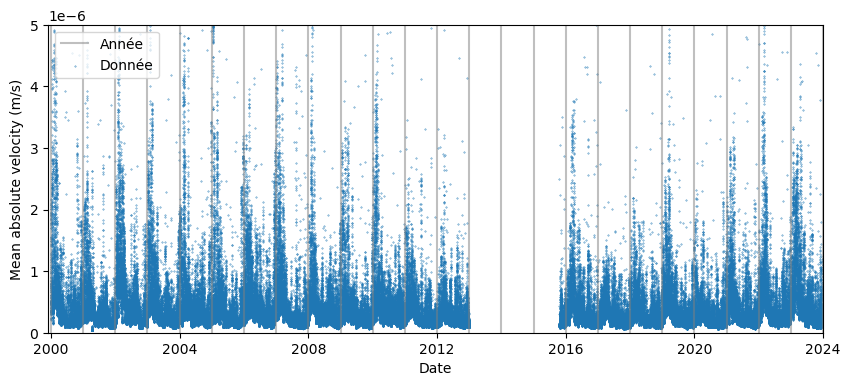

In [39]:
plt.figure(figsize=(10, 4))

label = 'Année'
for year in range(2000, 2025):
    plt.axvline(datetime(year, 1, 1), c='grey', alpha=.5, label=label)
    label=None
   
plt.scatter(datetimes, mean_velocities, s=.1, label='Donnée')
plt.xlabel('Date')
plt.ylabel('Mean absolute velocity (m/s)')
plt.xlim(datetime(1999, 12, 1), datetime(2024, 1, 1))
plt.ylim(0, 5e-6)
plt.legend(loc=2)

In [19]:
date_range = pd.date_range('1/1/2000', '31/12/2023', freq='D')
date_range

DatetimeIndex(['2000-01-01', '2000-01-02', '2000-01-03', '2000-01-04',
               '2000-01-05', '2000-01-06', '2000-01-07', '2000-01-08',
               '2000-01-09', '2000-01-10',
               ...
               '2023-12-22', '2023-12-23', '2023-12-24', '2023-12-25',
               '2023-12-26', '2023-12-27', '2023-12-28', '2023-12-29',
               '2023-12-30', '2023-12-31'],
              dtype='datetime64[ns]', length=8766, freq='D')

In [20]:
events_series = pd.Series(pd.to_datetime([dt.date() for dt in datetimes]))
events_series

0        2000-01-01
1        2000-01-01
2        2000-01-01
3        2000-01-01
4        2000-01-01
            ...    
185085   2023-12-31
185086   2023-12-31
185087   2023-12-31
185088   2023-12-31
185089   2023-12-31
Length: 185090, dtype: datetime64[ns]

In [21]:
count = events_series.value_counts()
count = count.sort_index()
count

2000-01-01     5
2000-01-02    24
2000-01-03    24
2000-01-04    24
2000-01-05    24
              ..
2023-12-27    24
2023-12-28    24
2023-12-29    24
2023-12-30    24
2023-12-31    24
Name: count, Length: 7736, dtype: int64

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

(<Figure size 1000x3910 with 23 Axes>,
 array([<Axes: ylabel='2023'>, <Axes: ylabel='2022'>,
        <Axes: ylabel='2021'>, <Axes: ylabel='2020'>,
        <Axes: ylabel='2019'>, <Axes: ylabel='2018'>,
        <Axes: ylabel='2017'>, <Axes: ylabel='2016'>,
        <Axes: ylabel='2015'>, <Axes: ylabel='2013'>,
        <Axes: ylabel='2012'>, <Axes: ylabel='2011'>,
        <Axes: ylabel='2010'>, <Axes: ylabel='2009'>,
        <Axes: ylabel='2008'>, <Axes: ylabel='2007'>,
        <Axes: ylabel='2006'>, <Axes: ylabel='2005'>,
        <Axes: ylabel='2004'>, <Axes: ylabel='2003'>,
        <Axes: ylabel='2002'>, <Axes: ylabel='2001'>,
        <Axes: ylabel='2000'>], dtype=object))

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

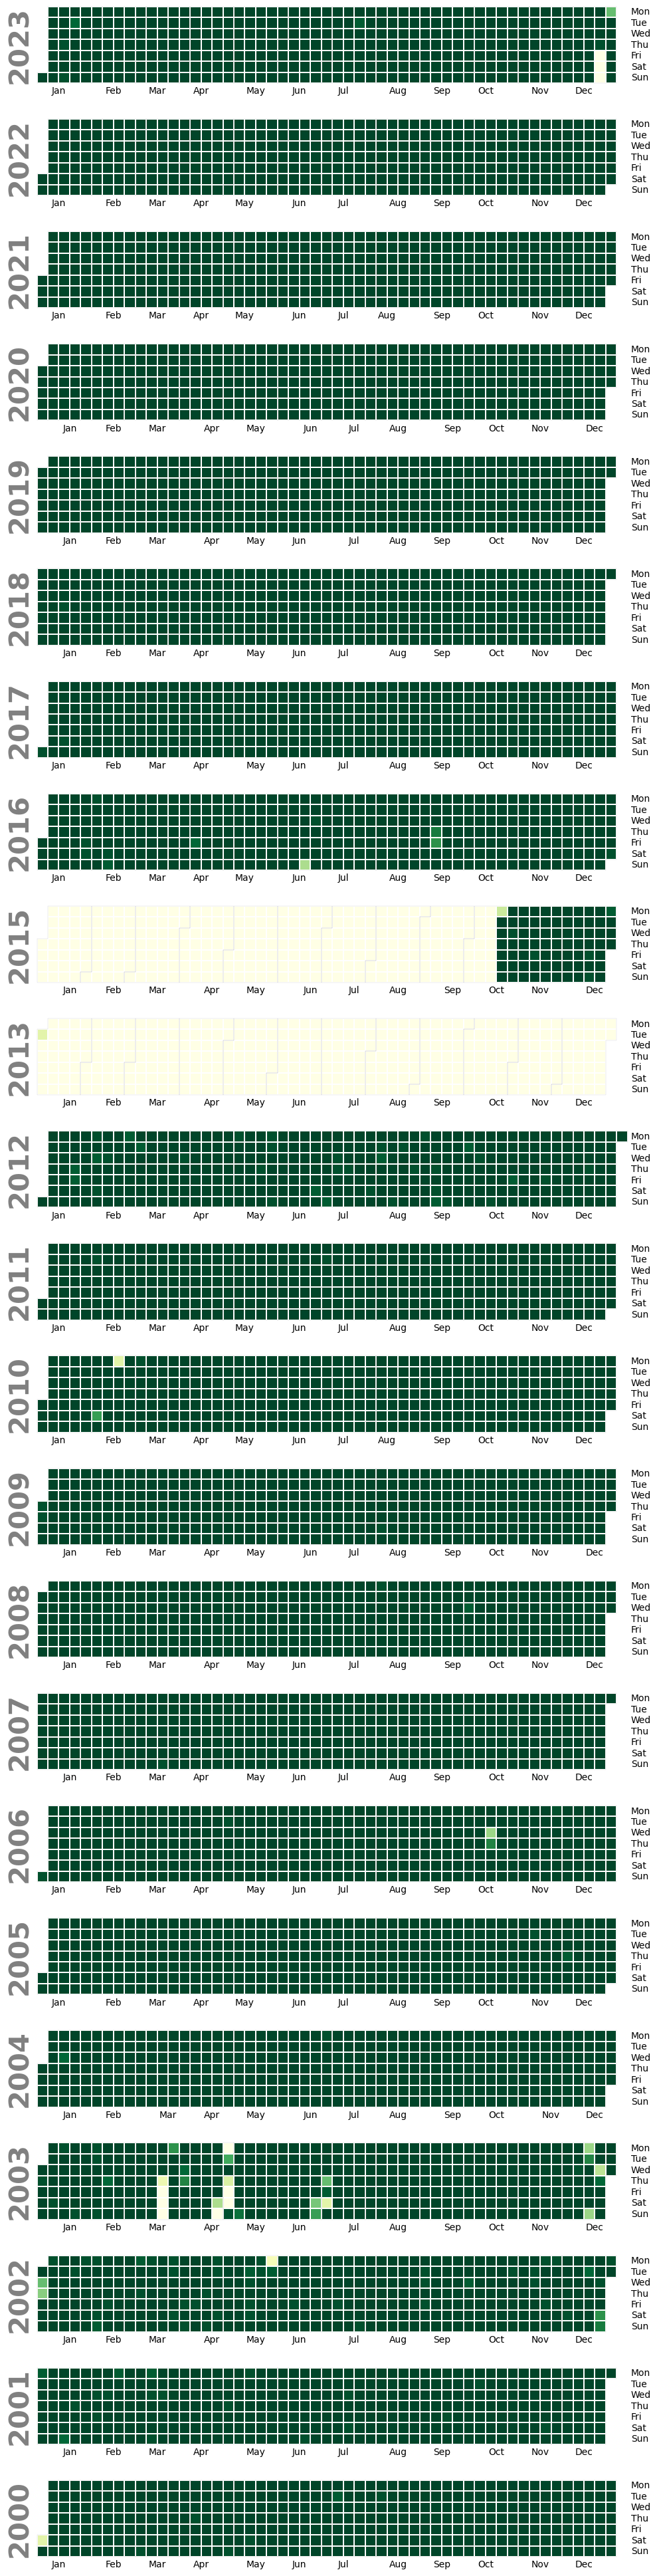

In [22]:
calplot.calplot(count, cmap='YlGn', linewidth=0.1, colorbar = False, yearascending=False)

In [48]:
velocity_serie = pd.Series(mean_velocities).set_axis(events_series)
velocity_serie

2000-01-01    2.468214e-07
2000-01-01    2.322491e-07
2000-01-01    2.302085e-07
2000-01-01    2.258093e-07
2000-01-01    2.140479e-07
                  ...     
2023-12-31    6.966056e-07
2023-12-31    7.228777e-07
2023-12-31    7.102285e-07
2023-12-31    7.198619e-07
2023-12-31    7.019413e-07
Length: 185090, dtype: float64

In [49]:
velocity_serie = velocity_serie.groupby(velocity_serie.index.floor('D')).mean()

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

(<Figure size 1000x3910 with 23 Axes>,
 array([<Axes: ylabel='2023'>, <Axes: ylabel='2022'>,
        <Axes: ylabel='2021'>, <Axes: ylabel='2020'>,
        <Axes: ylabel='2019'>, <Axes: ylabel='2018'>,
        <Axes: ylabel='2017'>, <Axes: ylabel='2016'>,
        <Axes: ylabel='2015'>, <Axes: ylabel='2013'>,
        <Axes: ylabel='2012'>, <Axes: ylabel='2011'>,
        <Axes: ylabel='2010'>, <Axes: ylabel='2009'>,
        <Axes: ylabel='2008'>, <Axes: ylabel='2007'>,
        <Axes: ylabel='2006'>, <Axes: ylabel='2005'>,
        <Axes: ylabel='2004'>, <Axes: ylabel='2003'>,
        <Axes: ylabel='2002'>, <Axes: ylabel='2001'>,
        <Axes: ylabel='2000'>], dtype=object))

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

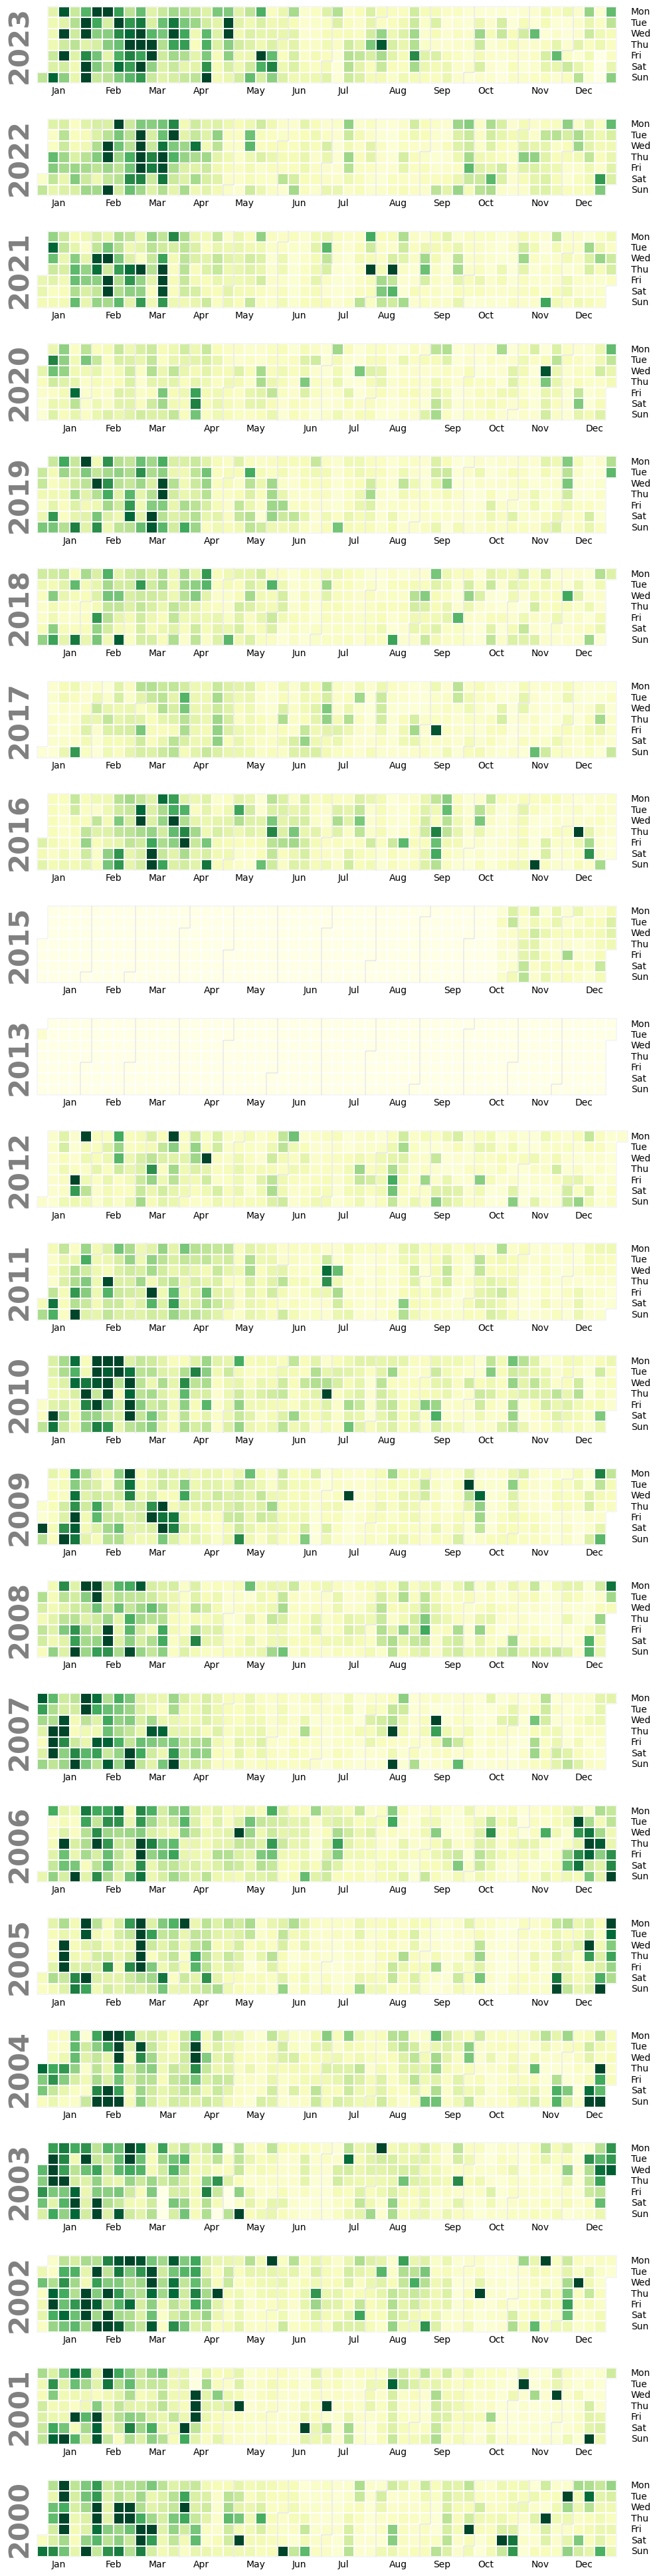

In [61]:
calplot.calplot(velocity_serie, cmap='YlGn', linewidth=0.1, colorbar = False, yearascending=False, vmin=0, vmax=2e-6)

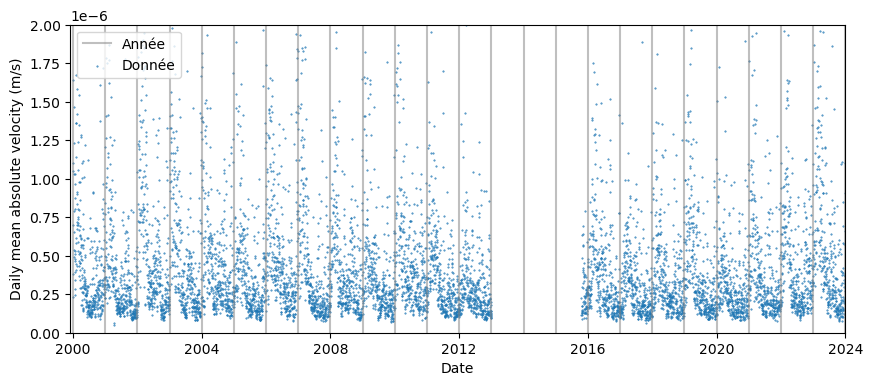

In [66]:
plt.figure(figsize=(10, 4))

label = 'Année'
for year in range(2000, 2025):
    plt.axvline(datetime(year, 1, 1), c='grey', alpha=.5, label=label)
    label=None
   
plt.scatter(velocity_serie.index, velocity_serie, s=.2, label='Donnée')
plt.xlabel('Date')
plt.ylabel('Daily mean absolute velocity (m/s)')
plt.xlim(datetime(1999, 12, 1), datetime(2024, 1, 1))
plt.ylim(0, 2e-6)
plt.legend(loc=2)